In [51]:
import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from gensim.utils import simple_preprocess
import seaborn as sns

import string
#import spacy
import os
import seaborn as sns
import xgboost

from sklearn.preprocessing import normalize,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import naive_bayes, svm, ensemble
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix,mean_squared_error, r2_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from scipy.sparse import hstack, csr_matrix
from sklearn.utils import class_weight

from keras.utils import to_categorical
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,Flatten,Conv1D,MaxPooling1D,Activation,GRU
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim
from gensim.utils import simple_preprocess

# create a tokenizer 
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_colwidth", 200)

In [2]:
pd.set_option('max_colwidth', 2000)

# Loading Datasets - train, test & sample

In [3]:
train = pd.read_csv('../train.csv')
train.head(1)

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,"Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.",gilenya,2


In [4]:
test = pd.read_csv('../test.csv')
test.head(2)

,unique_hash,text,drug
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 55% switching to fingolimod",fingolimod
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,On fingolimod and have been since December 2015; the only way I can describe it any better is like feeling drunk but without having had a drink!!!,fingolimod


In [15]:
sample = pd.read_csv('../sample_submission.csv')
sample.head(1)

,id,sentiment
0,9e9a8166b84114aca147bf409f6f956635034c08,0


In [3]:
train.head(1)

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2


# EDA Before Preprocessing Data

In [5]:
def gen_freq(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()

    #Print top 20 words
    word_freq[:20]
    
    return word_freq

gen_freq(train.text.str)

the          61123
of           44248
to           43476
and          43014
a            29922
             ...  
0820             1
Theodor          1
Stappler         1
0910-1010        1
popular),        1
Length: 105179, dtype: int64

## Wordcloud for train

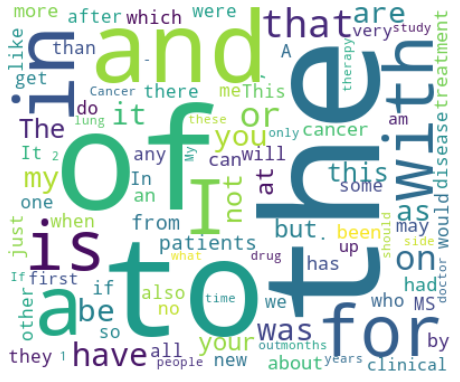

In [6]:
#Generate word cloud

word_freq = gen_freq(train.text.str)

wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(8,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Wordcloud for test

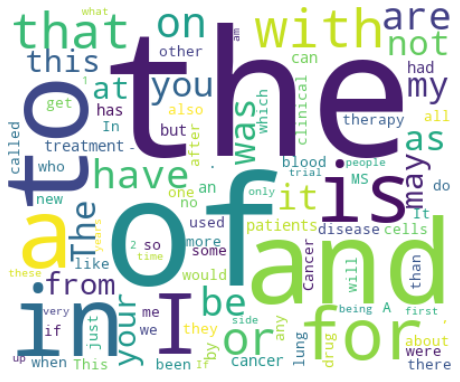

In [7]:
#Generate word cloud

word_freq = gen_freq(test.text.str)

wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(8,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Preprocessing

In [38]:
punctuation = string.punctuation

stopword = stopwords.words("english")

lem = WordNetLemmatizer()

def _clean(text):
    text = text.lower()
    
    #Remove url links
    text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', text)
    
    #EMOJIS
    text = re.sub(r":\)","emoji happy",text)
    text = re.sub(r":P","emoji happy",text)
    text = re.sub(r":p","emoji happy",text)
    text = re.sub(r":>","emoji happy",text)
    text = re.sub(r":3","emoji happy",text)
    text = re.sub(r":D","emoji happy",text)
    text = re.sub(r" XD ","emoji happy",text)
    text = re.sub(r" <3 ","emoji happy",text)
    
    text = re.sub(r":\(","emoji sad",text)
    text = re.sub(r":<","emoji sad",text)
    text = re.sub(r":<","emoji sad",text)
    text = re.sub(r">:\(","emoji sad",text)
    
    #text = re.sub(r"\'", "\'", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"dont", "do not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " had", text)
    #text = re.sub(r"\d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    #text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'am", " am", text)
    text = re.sub(r"\n", "", text)    
    text = re.sub(r"\r", "", text)
    text = re.sub(r",", " ", text)
    
    words = text.split()
    words = [w for w in words if w not in stopword]
    text = " ".join(words)
    
    text = "".join(x for x in text if x not in punctuation)
    
    text = re.sub(r'(([^a-zA-Z0-9]))', ' ', text)
    #text = re.sub(r'(([^a-zA-Z]))', ' ', text)
    
    words = text.split()
    words = [w for w in words if len(w)>1]
    text = " ".join(words)
    #cleandata = [' '.join([w for w in x.split() if len(w)>1]) for x in cleandata]
    
    text = re.sub(r'\s+', ' ', text)
    
    words = text.split()
    
    words = [lem.lemmatize(word, "v") for word in words]
    words = [lem.lemmatize(word, "n") for word in words]
    words = [w for w in words if w not in stopword]
    
    text = " ".join(words)
    
    return text

#_clean("This IS A Sample text!!!")
_clean("and is applied to the periphery don't I'am  informing I I've won't you'll of the retina. :) :( There is I'am some good information about injections for macular oedema here:-  http://www.diabeticretinopathy.org.uk/lucentispatientsdr.htm and good 3 information 22 about laser treatment here:-")

'apply periphery inform retina emoji happy emoji sad good information injection macular oedema URL good information 22 laser treatment'

In [39]:
train['cleaned'] = train['text'].apply(_clean)

In [10]:
train.head(1)

,unique_hash,text,drug,sentiment,cleaned
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,"Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.",gilenya,2,autoimmune disease tend come cluster gilenya feel good think win change anything waste time energy take tysabri feel amaze symptom dodgy color vision since always know know last month year decade ive decide enjoy ride point worry


In [14]:
train.to_csv('sentimentAnalysisForDrugsAndMedicines/trainCleaned.csv',index=False)

In [40]:
test['cleaned'] = test['text'].apply(_clean)

In [12]:
test.head(1)

,unique_hash,text,drug,cleaned
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 55% switching to fingolimod",fingolimod,previously stable natalizumab switch fingolimod


In [15]:
test.to_csv('sentimentAnalysisForDrugsAndMedicines/testCleaned.csv',index=False)

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

train['text'] = train['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)

# EDA

In [16]:
train['drug'].value_counts()

ocrevus            676
gilenya            666
ocrelizumab        441
entyvio            303
humira             270
                  ... 
infliximab-dyyb      1
pf-00547659          1
geftinib             1
alunbrig             1
cyramza              1
Name: drug, Length: 102, dtype: int64

In [17]:
train.sentiment.value_counts()

2    3825
1     837
0     617
Name: sentiment, dtype: int64

## Wordcloud of clean train text

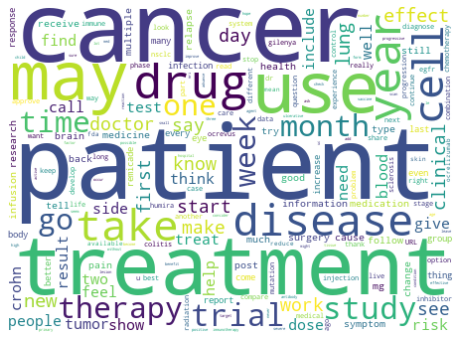

In [18]:
word_freq = gen_freq(train['cleaned'].str)
word_freq = word_freq.drop(labels=STOPWORDS, errors='ignore')

#Generate word cloud
wc = WordCloud(width=450, height=330, max_words=200, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(8, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Wordcloud of clean test text

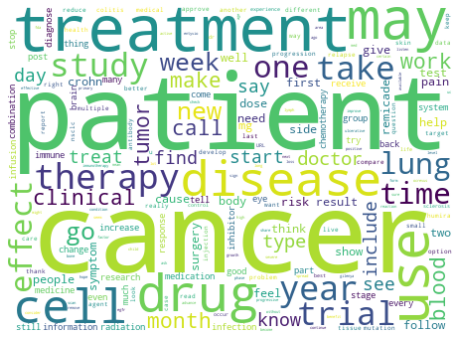

In [19]:
word_freq = gen_freq(test['cleaned'].str)
word_freq = word_freq.drop(labels=STOPWORDS, errors='ignore')

#Generate word cloud
wc = WordCloud(width=450, height=330, max_words=200, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(8, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<AxesSubplot:xlabel='sentiment', ylabel='count'>

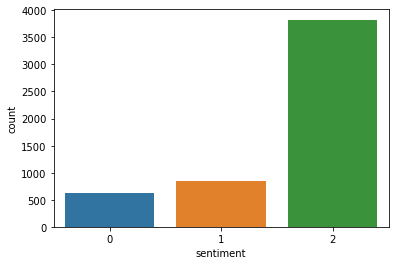

In [20]:
sns.countplot(x='sentiment', data=train)

In [21]:
drugs = train['drug'].value_counts().head(20)
df = pd.DataFrame()
df['xaxis'] = drugs.index
df['yaxis'] = drugs.values
print(df.head(2))

     xaxis  yaxis
0  ocrevus    676
1  gilenya    666


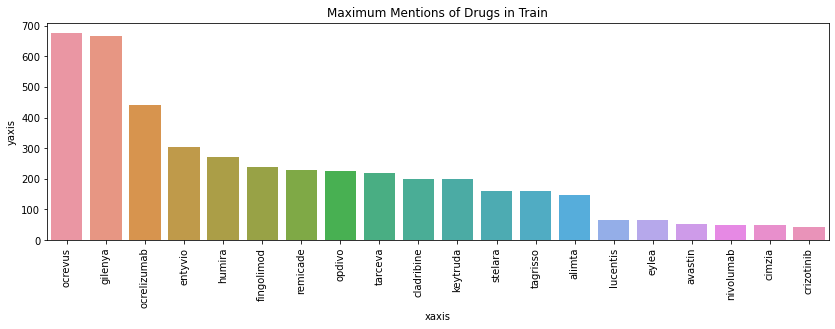

In [22]:
plt.figure(figsize=(14,4))
sns.barplot(x = 'xaxis',y = 'yaxis', data=df)
plt.xticks(rotation=90)
plt.title('Maximum Mentions of Drugs in Train')
plt.show()

In [23]:
drugs = test['drug'].value_counts().head(20)
df = pd.DataFrame()
df['xaxis'] = drugs.index
df['yaxis'] = drugs.values
print(df.head(2))

     xaxis  yaxis
0  gilenya    311
1  ocrevus    302


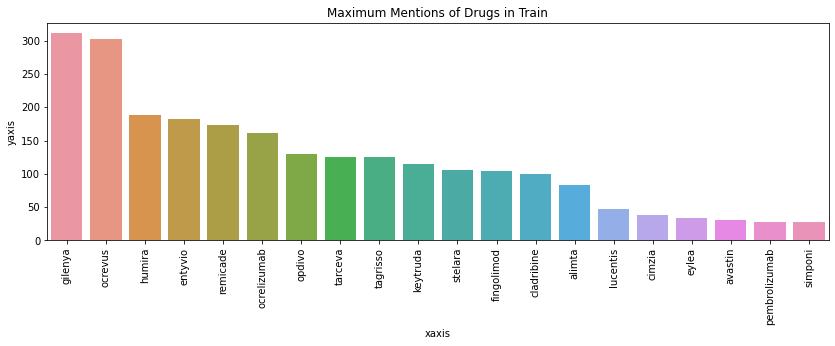

In [24]:
plt.figure(figsize=(14,4))
sns.barplot(x = 'xaxis',y = 'yaxis', data=df)
plt.xticks(rotation=90)
plt.title('Maximum Mentions of Drugs in Train')
plt.show()

In [25]:
# function to plot top 30 most frequent words
def freq_words(x,t = 'Common Words'):
    terms = 30
    # combine all the articles  
    text = ' '.join([text for text in x])
    # split text into words   
    all_words = text.split()
    
    # prepare a dictionary of word-frequency pairs
    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top n most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    
    # plot the word counts  
    plt.figure(figsize=(14,4))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.title(t)
    plt.xticks(rotation=90)
    plt.show()

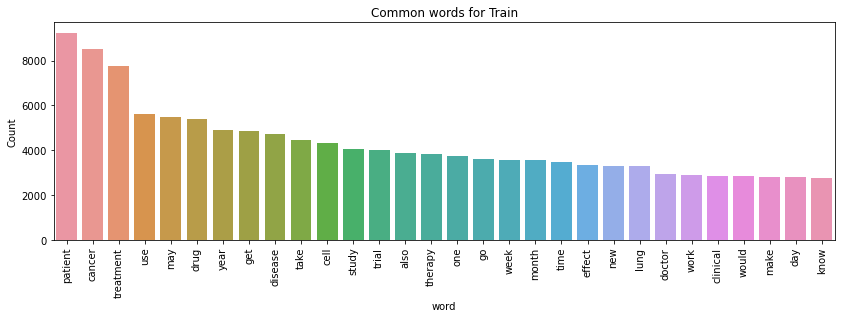

In [26]:
freq_words(train['cleaned'],'Common words for Train')

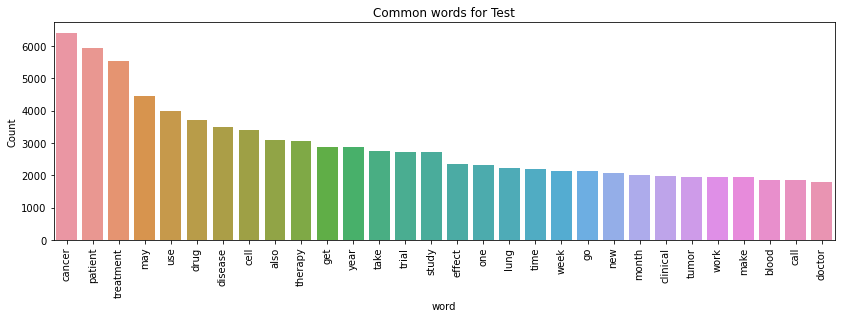

In [27]:
freq_words(test['cleaned'],'Common words for Test')

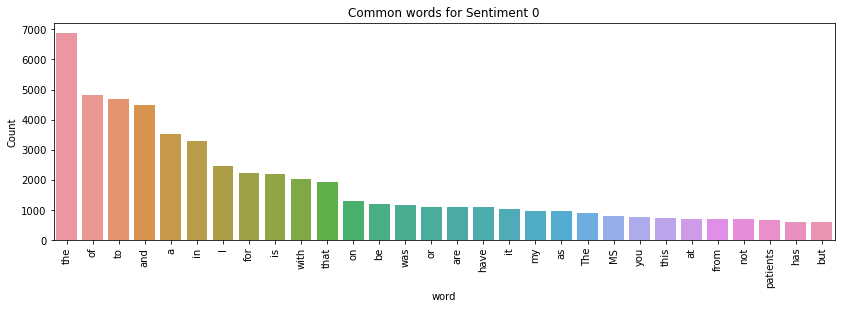

In [28]:
freq_words(train[train['sentiment'] == 0]['text'],'Common words for Sentiment 0')

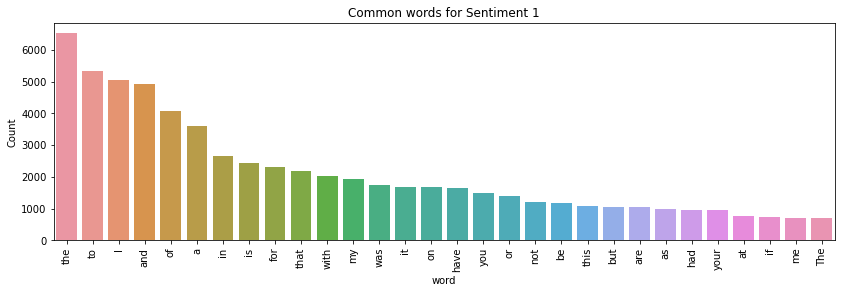

In [30]:
freq_words(train[train['sentiment'] == 1]['text'],'Common words for Sentiment 1')

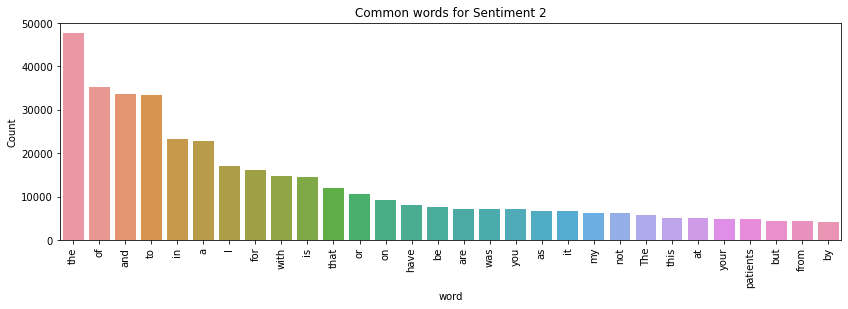

In [31]:
freq_words(train[train['sentiment'] == 2]['text'],'Common words for Sentiment 2')

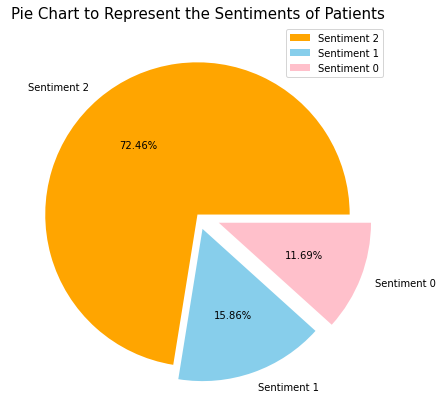

In [32]:
# a pie chart to represent the sentiments of the patients

size = [3825, 837, 617]
colors = ['orange', 'skyblue','pink']
labels = "Sentiment 2","Sentiment 1","Sentiment 0"
explode = [0, 0.1,0.15]

plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size, colors = colors, labels = labels, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart to Represent the Sentiments of Patients', fontsize = 15)
plt.legend()
plt.show()

# Feature Engineering

In [34]:
# Meta features 

# word count for train
train["word_count"] = train["text"].apply(lambda x : len(x.split()))
#train["word_count"] = train["cleaned"].apply(lambda x : len(x.split()))

# char count for train
train["char_count"] = train["text"].apply(lambda x : len(x))
train["char_count_without_spaces"] = train["text"].apply(lambda x : len(x.replace(" ","")))

# word count for test
test["word_count"] = test["text"].apply(lambda x : len(x.split()))

# char count for test
test["char_count"] = test["text"].apply(lambda x : len(x))
test["char_count_without_spaces"] = test["text"].apply(lambda x : len(x.replace(" ","")))

#  no. of digits
# for sentiment analysis numbers don't have much impact
#train["num_dig"] = train["text"].apply(lambda x :  sum([1 if w.isdigit() else 0 for w in x.split()]))

In [35]:
pos_dic = {"noun" : ["NNP", "NN", "NNS", "NNPS"], "verb" : ["VBZ", "VB", "VBD","VBG", "VBN"]}
import nltk
def pos_check(txt, family):
    tags = nltk.pos_tag(nltk.word_tokenize(txt))
    count = 0
    for tag in tags:
        tag = tag[1]
        if tag in pos_dic[family]:
            count += 1 
    return count

train["noun_count"] = train["text"].apply(lambda x : pos_check(x, "noun"))
train["verb_count"] = train["text"].apply(lambda x : pos_check(x, "verb"))
test["noun_count"] = test["text"].apply(lambda x : pos_check(x, "noun"))
test["verb_count"] = test["text"].apply(lambda x : pos_check(x, "verb"))

In [36]:
train.to_csv('trainMeta.csv',index=False)

In [37]:
test.to_csv('testMeta.csv',index=False)

In [5]:
train.head(1)

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,autoimmune diseases tend come clusters for gil...,gilenya,2


In [7]:
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['sentiment'], test_size=0.25, stratify=train['sentiment'],random_state=1)

In [56]:
# new
X_train, X_test, y_train, y_test = train_test_split(train['cleaned'], train['sentiment'], test_size=0.25, stratify=train['sentiment'],random_state=1)

In [57]:
tfidf_vect = TfidfVectorizer(analyzer='word',min_df=3)

In [58]:
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [44]:
# new
sgd = SGDClassifier(loss='log', max_iter=200, random_state=0, class_weight='balanced')
ovr = OneVsRestClassifier(sgd)
ovr.fit(X_train_tfidf, y_train)
y_pred_class = ovr.predict(X_test_tfidf)
print('f1_score       :', f1_score(y_test, y_pred_class, average='macro'))
print('accuracy score :', accuracy_score(y_test, y_pred_class))

f1_score       : 0.514256968099535
accuracy score : 0.6628787878787878


In [11]:
sgd = SGDClassifier(loss='log', max_iter=200, random_state=0, class_weight='balanced')
ovr = OneVsRestClassifier(sgd)
ovr.fit(X_train_tfidf, y_train)
y_pred_class = ovr.predict(X_test_tfidf)
print('f1_score       :', f1_score(y_test, y_pred_class, average='macro'))
print('accuracy score :', accuracy_score(y_test, y_pred_class))

f1_score       : 0.5145775153047341
accuracy score : 0.6613636363636364


In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word',min_df=3)

In [45]:
# new
full_text = list(train['cleaned'].values) + list(test['cleaned'].values)
tfidf_vect.fit(full_text)

X_train_tfidf = tfidf_vect.transform(train['cleaned'])
X_test_tfidf = tfidf_vect.transform(test['cleaned'])

y_train = train['sentiment']

In [13]:
full_text = list(train['text'].values) + list(test['text'].values)
tfidf_vect.fit(full_text)

X_train_tfidf = tfidf_vect.transform(train['text'])
X_test_tfidf = tfidf_vect.transform(test['text'])

y_train = train['sentiment']

In [46]:
# new
sgd = SGDClassifier(loss='log', max_iter=200, random_state=0, class_weight='balanced')
ovr = OneVsRestClassifier(sgd)
ovr.fit(X_train_tfidf, y_train)
y_pred_class = ovr.predict(X_test_tfidf)
y_pred_class

array([2, 1, 2, ..., 0, 2, 2], dtype=int64)

In [14]:
sgd = SGDClassifier(loss='log', max_iter=200, random_state=0, class_weight='balanced')
ovr = OneVsRestClassifier(sgd)
ovr.fit(X_train_tfidf, y_train)
y_pred_class = ovr.predict(X_test_tfidf)
y_pred_class

array([2, 1, 2, ..., 2, 2, 2], dtype=int64)

In [47]:
# new
samples = pd.DataFrame()
samples['id'] = test['unique_hash']
test['sentiment'] = y_pred_class
samples['sentiment'] = test['sentiment']
#test.drop(['text','drug'], axis=1,inplace=True)
#test.head()
samples.head(1)

,id,sentiment
0,9e9a8166b84114aca147bf409f6f956635034c08,2


In [16]:
samples = pd.DataFrame()
samples['id'] = test['unique_hash']
test['sentiment'] = y_pred_class
samples['sentiment'] = test['sentiment']
#test.drop(['text','drug'], axis=1,inplace=True)
#test.head()
samples.head(1)

,id,sentiment
0,9e9a8166b84114aca147bf409f6f956635034c08,2


In [48]:
#new
samples['sentiment'].value_counts()

2    2005
1     516
0     403
Name: sentiment, dtype: int64

In [17]:
samples['sentiment'].value_counts()

2    1958
0     487
1     479
Name: sentiment, dtype: int64

In [19]:
#test.to_csv('submission.csv', index=False)
samples.to_csv('sentimentAnalysisForDrugsAndMedicines/samplessubmitsgdovr.csv',index=False)

In [49]:
# 0.4807
# new
samples.to_csv('sentimentAnalysisForDrugsAndMedicines/samplessubmitsgdovr1.csv',index=False)